# Preventive Medical Screening in Unborn

During the 5th week of gestation, a heartbeat-like **signal** can be detected in the embryo for the
first time. However, the unborn has to develop further for this signal to carry relevant medical
information. After the embryo evolved into a fetus, **heartbeat measurement can be a valuable
technique to measure fetal distress, avoid unecessary cesarean sections and detect pathologic
development** early on.

Based on inspection of frequency, amplitude and other properties of the fetal heartbeat, various diseases can be directly diagnosed or other investigative tools can be selected. However,
recording and isolating a clear signal in the maternal abdomen is tedious and requires complex machinery. Thus, an easier and more accessible method for recording is a **multi-electrode
system** that is placed to the mother’s abdomen. 

Combining the information provided by the
individual electrodes, digestive noise and maternal heartbeat can be **filtered out to obtain a
reliable fetal heartbeat signal**.

## Data Visualization

Synthetic maternal abdomen multi electrode ECG recordings

* Each file is an independent recording of a patient.
* Each file contains 4 electrodes and therefore 4 recorded channels.
* The sampling rate of each channel is 360 Hz.
* Some of the fetal heartbeat signals contain pathologies, try to detect them.

In [3]:
# Import all necessary dependencies (pleaes write new dependencies in this snippet.)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import FastICA

In [5]:

# load a data example
data = loadmat("data/000.mat")

# Get the values from the mat file
values = data['val']

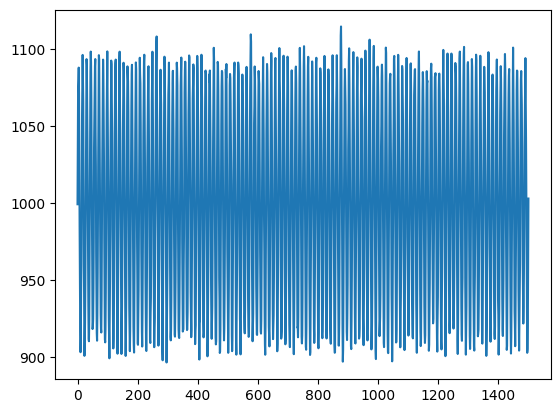

In [6]:
# Create the X and y datasets
y = values[0][0]
X = np.linspace(0, len(y), len(y))


# Plot them
plt.figure()
plt.plot(X, y)
plt.show()

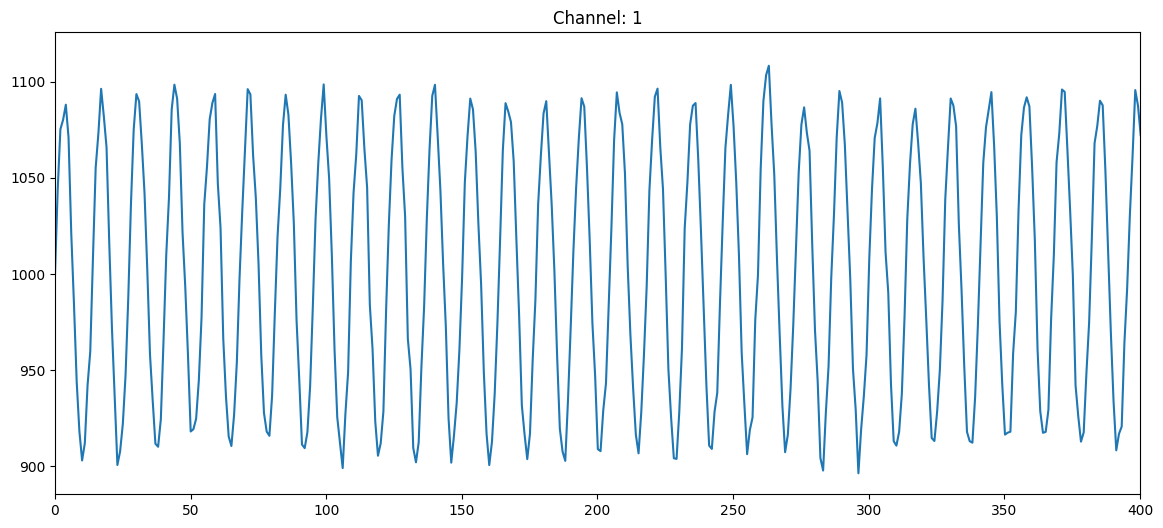

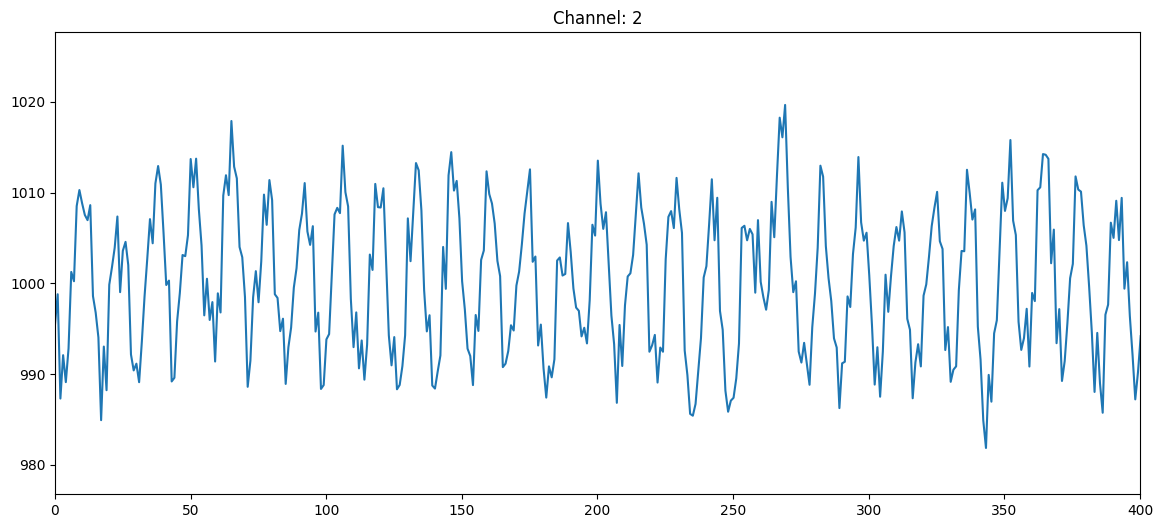

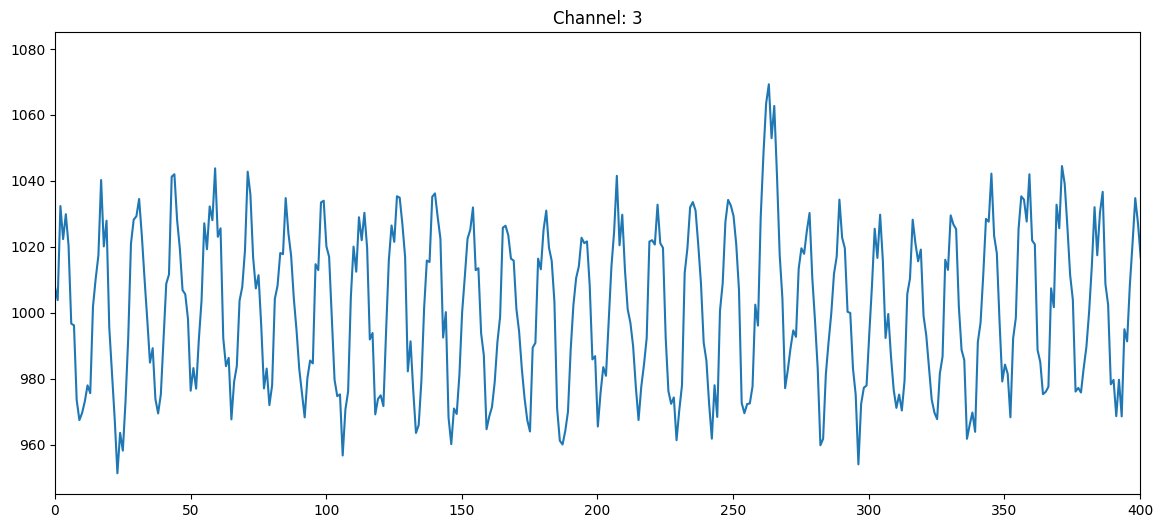

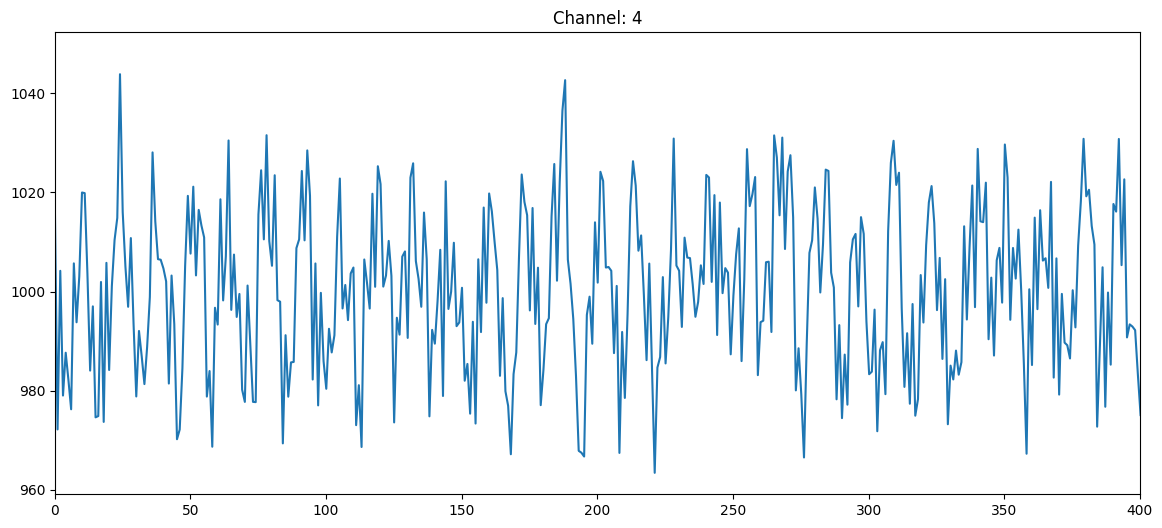

In [7]:
# Plot all the channels of one data

for i in range(0, 4):
    plt.figure(figsize=(14, 6))
    plt.plot(X, values[0][i])
    plt.title(f"Channel: {i+1}")
    plt.xlim([0, 400])
    plt.show()